# Project 2: Supervised Learning
### Building a Student Intervention System
<sub>Uirá Caiado. April 13, 2016<sub>

#### Abstract

_There exists a push from educators and administrators to raise the likelihood of students successfully complete their programs. The aim of this project is to identify students who need intervention before they drop out of school. My goal is to use concepts from supervised machine learning to find the most effective model with the least amount of computation costs that identify such students._

## 1. Introduction

In this section, I will give some background about the problem addressed and the goal of the project. I also will identify which type of model that will be developed.

### 1.1. Some Background
As stated by [Udacity](https://www.udacity.com/course/viewer#!/c-nd009/l-5446988865/m-5446493941) in the description for this project, as education has grown to rely more and more on technology, more and more data is available for examination and prediction. Logs of student activities, grades, interactions with teachers and fellow students, and more are now captured through learning management systems.

Within all levels of education, there exists a surge to help increase the likelihood of student success without watering down the education or engaging in behaviors that raise the probability of passing metrics without improving the actual underlying learning. Graduation rates are often the criteria of choice for this, and educators and administrators are after new ways to predict success and failure early enough to stage effective interventions, as well as to identify the effectiveness of different interventions.

### 1.2. The Goal

The goal for this project is implementing a student intervention system using concepts from Supervised Machine Learning. I am going to choose and develop a model that will predict the likelihood that a given student will pass, thus helping diagnose whether or not an intervention is necessary.

I will suppose that the data available to create the model is a representative but a small sample of the dataset that I would have access in the production environmet. So, besides the typical accuracy requirements for any machine-learning project, I am also going to look for models that are efficient in the use of resources (computation time and memory). Thus, the model will be evaluated on three factors:

- Its [F1](https://en.wikipedia.org/wiki/F1_score) Score, summarizing the number of correct positives and correct negatives out of all posible cases. In other words, how well does the model differentiate likely passes from failures

- The size of the training set, preferring smaller training sets over larger ones. That is, how much data does the model need to make a reasonable prediction?

- The computation resources to make a reliable prediction. How much time and memory is required to correctly identify students that need intervention?

### 1.3 Classification vs Regression

```
Udacity:
Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?
```

The model that will be developed is a Classifier. According to \cite{Hastie_2009}, the distinction in the output type has led to a naming convention for prediction tasks: _regression_ when we predict quantitative (continuous) outputs, and _classification_ when we predict qualitative outputs (discrete). As the goal of this project is to identify if the student will succeed, the problem posed is a classification problem once it requires a binary answer (passed, failed).

## 2. Exploring the Data

In this section, we will explore the data to look for insides about the features.

### 2.1. Basic Facts

```
Udacity: Let's go ahead and read in the student dataset first. To execute a code cell, click inside it and press Shift+Enter.
```
Let's go ahead and execute a basic description of the student dataset:

In [1]:
# Import libraries
import numpy as np
import pandas as pd

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


```
Udacity:
Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features
Use the code block below to compute these values. Instructions/steps are marked using TODOs.
```

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.shape[0]
n_features = student_data.shape[1]
n_passed = sum((student_data.passed=="yes"))
n_failed = sum((student_data.passed=="no"))
grad_rate = (n_passed *1./(n_failed+n_passed))*100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features - 1)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


All the 30 features in the dataset are discrete and Qualitative. There are 13 binary data, 13 ordered categorical variables and other 4 Categorical features. Among them, there are variables such as Father's Job, Family Size, if the student wants to take higher education or if he/she is in a romantic relationship. The data offers a pretty comprehensive profile of student life. At this point, it 's hard to say what features are relevant or not. A complete description of each variable can be found on the Github [project page](https://github.com/udacity/machine-learning/tree/master/projects/student_intervention).

Due to the dataset imbalance, as pointed out by the Code Reviewer, the model will be evaluated using $F_1$ instead of accuracy. Also, there is no missing data on this dataset and no presence of "real" outliers.

### 2.2. How the features are spread out

Before moving on, I am going to plot each feature to see how each inner classes of each variable are divided between the target labels "Passed" and "Not Passed." Below is plotted the Categorical features of the dataset. Here is possible to see that when the guardian is not the mother nor the father, it is more likely that the pupil not pass. Also, when the mother's occupation is teaching (_Fjob_), is likely that the student to pass.

In [8]:
import plot_features; reload(plot_features);

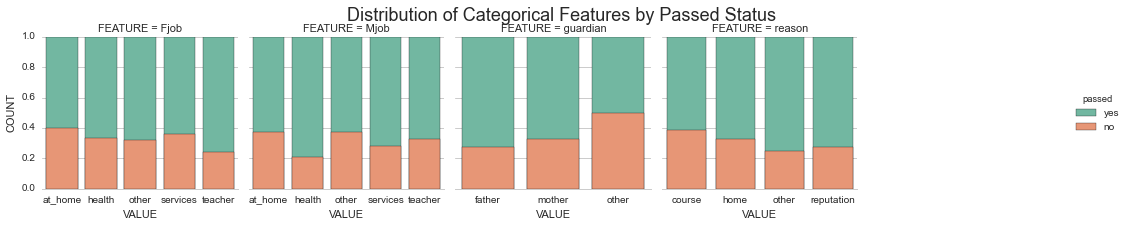

In [9]:
g = plot_features.bar_chart(student_data, i_plotGroup=1);

Looking at the Ordered Categorical Features, where there is an ordering of the values, the features _absences_, _age_ and _failure_ stand out. The _failures_ feature is the number of past class failures (n if 1<=n<3, else 4) and absences is the number of school absences. In all these variables, the bigger the number, the higher the likelihood of the student does not pass.

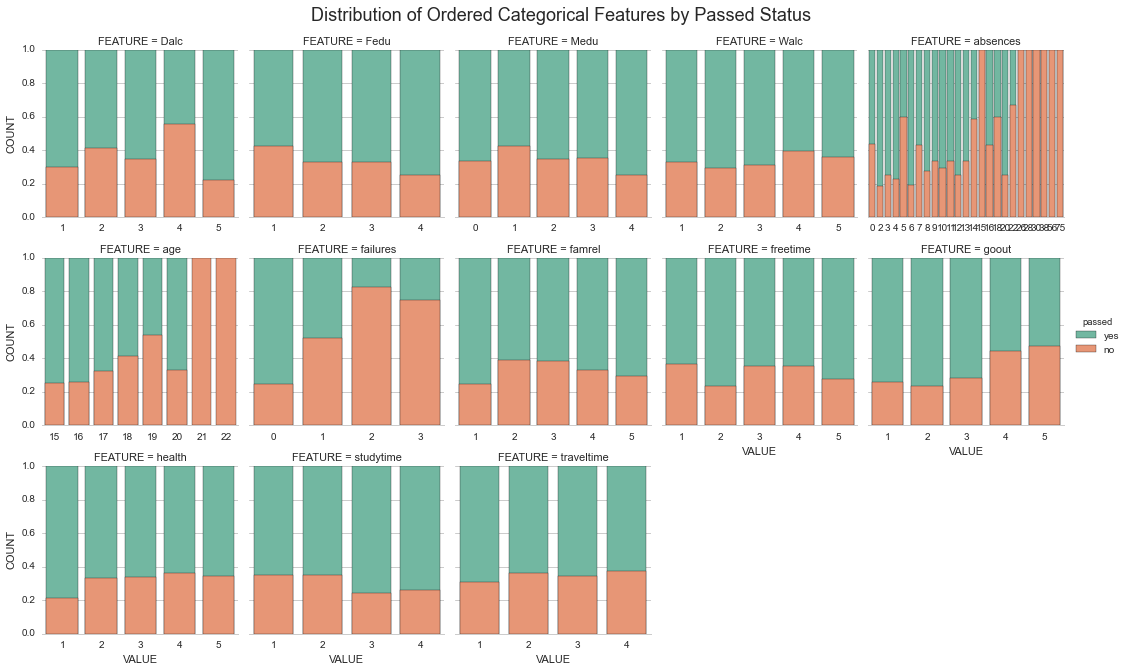

In [10]:
g = plot_features.bar_chart(student_data, i_plotGroup=2);

Finally, looking at the Binary Data, what more draw the attention are the features _higher_ and _schoolsup_. The feature _higher_ is if the student wants to take higher education and _schoolsup_ is if the student has extra educational support. Some features, as _activities_ and _nursery_, presented a very similar distribution between the classes

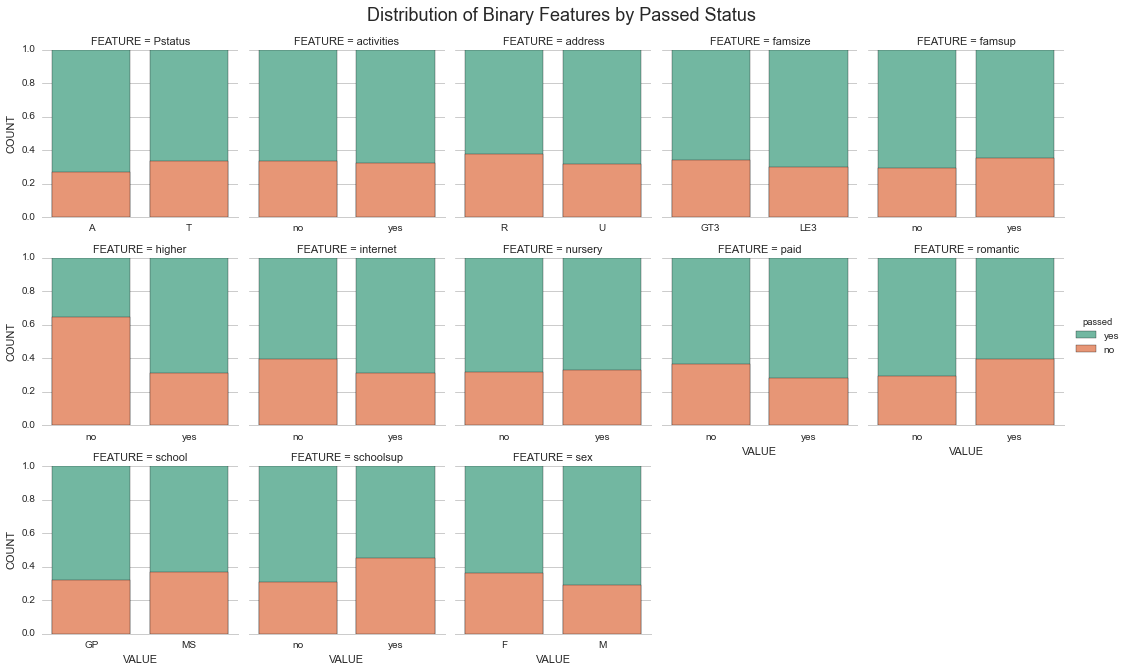

In [11]:
g = plot_features.bar_chart(student_data, i_plotGroup=3);

As can be seen, there are a lot of features that might add up to the classification process, although some features may be not so relevant It is important to notice that the model developed with this amount of data (365 data points) and variables (30) can suffer from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). Many of the features will be converted into dummy variables, what could increase the amount of data needed to build an accurate model. 

(_Exclude this part from final report_) Maybe would be interesting to test if treat the binary data as numerical to reduce the necessity to split into dummies (reducing the dimension of the dataset) can increase the performance. It will be made in section 5.

## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### 3.1. Identify feature and target columns
```
Udacity:
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.
```
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

In [12]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
# columns names
i = 0
s_rtn = ''
print "Feature column(s):\n==================="
for s in feature_cols:
    if i%4==0:
        s_rtn += "\n"
        s_rtn += "{:15s}".format(s)
    else:
        s_rtn += "\t{:15s}".format(s)
    i += 1
print s_rtn
print "\nTarget column:\n===================\n{}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:\n==================="
print X_all.ix[:, 0:8].head()  # print the first 5 rows

Feature column(s):

school         	sex            	age            	address        
famsize        	Pstatus        	Medu           	Fedu           
Mjob           	Fjob           	reason         	guardian       
traveltime     	studytime      	failures       	schoolsup      
famsup         	paid           	activities     	nursery        
higher         	internet       	romantic       	famrel         
freetime       	goout          	Dalc           	Walc           
health         	absences       

Target column:
passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu
0     GP   F   18       U     GT3       A     4     4
1     GP   F   17       U     GT3       T     1     1
2     GP   F   15       U     LE3       T     1     1
3     GP   F   15       U     GT3       T     4     2
4     GP   F   16       U     GT3       T     3     3


### 3.2. Preprocess feature columns
```
Udacity:
As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the `pandas.get_dummies()`(http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.
```
As can be seen above, there are several non-numeric columns in the dataset that need to be converted. The easiest case is when are only two categories, as "yes" or "no", e.g. _internet_. These are often represented by single binary digit as $0$ or $1$.

According to \cite{Hastie_2009}, when there are more than two categories, the most commonly alternative used is coding via [_dummy variables_](https://www.moresteam.com/whitepapers/download/dummy-variables.pdf). This method consists in representing a $K$-Level qualitative variable by a vector of $K$ binary variables, where only one of which is "on" at a time.

So, for example, the _Fjob_ feature will be split into $5$ new features ( *Fjob_teacher*, *Fjob_other*, *Fjob_services*, etc.), and will be assigned a $1$ to one of them and $0$ to all other columns.

This transformation will be performed using the pandas function `get_dummies()`. Initially, all binary data that the classes do not correspond to $yes$/$no$ will be converted into dummies.


In [13]:
# Preprocess feature columns
def preprocess_features(X, b_covertAll=False):
    '''
    Reshape the feature array to include dummy variables
    :param X: numpy array. Features
    :param b_covertAll: boolean. If should convert all binary data to 0/1
    '''
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty
    d_convert = {"yes": ['yes', 'no'], "no": ['yes', 'no'], "A": ['A', 'T'], "T": ['A', 'T'],
                 "R": ['R', 'U'], "U": ['R', 'U'], "GT3": ['GT3', 'LE3'], "LE3": ['GT3', 'LE3'],
                 "GP": ['GP', 'MS'], "MS": ['GP', 'MS'], "F": ['F', 'M'], "M": ['F', 'M']}
    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if not b_covertAll:
            if col_data.dtype == object:
                col_data = col_data.replace(['yes', 'no'], [1, 0])
            # Note: This should change the data type for yes/no columns to int
        else:
            if col_data.dtype == object:
                if col_data[0] in d_convert.keys():
                    col_data = col_data.replace(d_convert[col_data[0]], [1, 0])

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all1 = preprocess_features(X_all)
print "Processed feature columns ({}):\n===================".format(len(X_all1.columns))
s_rtn = ""
i = 0
for s in list(X_all1.columns):
    if i%3==0:
        s_rtn += "\n"
        s_rtn += "{:18s}".format(s)
    else:
        s_rtn += "\t{:18s}".format(s)
    i += 1
print s_rtn
print ''

Processed feature columns (48):

school_GP         	school_MS         	sex_F             
sex_M             	age               	address_R         
address_U         	famsize_GT3       	famsize_LE3       
Pstatus_A         	Pstatus_T         	Medu              
Fedu              	Mjob_at_home      	Mjob_health       
Mjob_other        	Mjob_services     	Mjob_teacher      
Fjob_at_home      	Fjob_health       	Fjob_other        
Fjob_services     	Fjob_teacher      	reason_course     
reason_home       	reason_other      	reason_reputation 
guardian_father   	guardian_mother   	guardian_other    
traveltime        	studytime         	failures          
schoolsup         	famsup            	paid              
activities        	nursery           	higher            
internet          	romantic          	famrel            
freetime          	goout             	Dalc              
Walc              	health            	absences          



(_Exclude this part from final report_) Now, all binary data will be converted into $0$/$1$ for future tests. The amount of features just reduced from 48 to 43.

In [14]:
X_all2 = preprocess_features(X_all,b_covertAll=True)
print "Processed feature columns ({}):\n===================".format(len(X_all2.columns))
s_rtn = ""
i = 0
for s in list(X_all2.columns):
    if i%3==0:
        s_rtn += "\n"
        s_rtn += "{:18s}".format(s)
    else:
        s_rtn += "\t{:18s}".format(s)
    i += 1
print s_rtn

Processed feature columns (43):

school            	sex               	age               
address           	famsize           	Pstatus           
Medu              	Fedu              	Mjob_at_home      
Mjob_health       	Mjob_other        	Mjob_services     
Mjob_teacher      	Fjob_at_home      	Fjob_health       
Fjob_other        	Fjob_services     	Fjob_teacher      
reason_course     	reason_home       	reason_other      
reason_reputation 	guardian_father   	guardian_mother   
guardian_other    	traveltime        	studytime         
failures          	schoolsup         	famsup            
paid              	activities        	nursery           
higher            	internet          	romantic          
famrel            	freetime          	goout             
Dalc              	Walc              	health            
absences          


### 3.3. Split data into training and test sets
```
Udacity:
So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.
```
So far, I have converted all _categorical_ features into numeric values. To be able to judge if the model chosen in the next section will generalize well from its experience, I will hold out part of the data to measure how the algorithms are performing on yet-unseen examples. In this next step, I am going to split the data (both features and corresponding labels) into training and test sets. I will use the function `cross_validation.train_test_split()` from _sklearn_ for that.

In [15]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
from sklearn.cross_validation import train_test_split

def shuffle_split_data(X, y):
    """ 
    Shuffles and splits data into 75% training and 25% testing subsets,
    then returns the training and testing subsets.
    :param X: numpy array. Features
    :param y: numpy array. Labels
    """
    # Shuffle and split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=0)
    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test


X_train ,y_train, X_test, y_test = shuffle_split_data(X_all1, y_all)
X_train2 ,y_train2, X_test2, y_test2 = shuffle_split_data(X_all2, y_all)
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 296 samples
Test set: 99 samples


## 4. Training and Evaluating Models
```
Udacity:
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F1 score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F1 score on training set and F1 score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.
```

As stated in Section 1, the model will be evaluated on three factors: $F_1$ Score, The size of the training set needed to build an acceptable model, and the computation resources used.
Before selecting the algorithms to test their performance and amount of data needed, I am going to check the resources that different Supervised Learning Algorithms take by training them using different sizes of data sets. 
After that, I will select three algorithms to describe and analyse their performance under different training set sizes using their learning curves

In [16]:
# Train a model
import time
from memory_profiler import memory_usage

def train_classifier(clf, X_train, y_train, shouldPrint=True):
    """
    Fit the model passed to the data provided
    :param clf: sklearn object. The Classifier to be trained
    :param X_train: numpy array. The features to train the model
    :param y_train: numpy array. The labels to fit the model
    :*param shouldPrint: boolean. If shoud print the output of the function
    """
    if shouldPrint:
        print "Training {}...".format(clf.__class__.__name__)
    start = time.time()

    f_memUsage = memory_usage((clf.fit,
                              (X_train, y_train)),
                              max_usage=True)
    
    
    end = time.time()
    if shouldPrint:
        s_print = "Done!\nTraining time (secs): {:.3f}\nPeak memory: {:.2f} MiB"
        print s_print.format(end - start, f_memUsage[0])
    return end - start, f_memUsage[0]

In [17]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target, shouldPrint=True):
    """
    Use a printed model to predict the labels to a given features set
    and measure its F1 score comparing to the target labels
    :param clf: sklearn object. The Classifier to be trained
    :param features: numpy array. The features to test the model
    :param target: numpy array. The labels to be compared
    :*param shouldPrint: boolean. If shoud print the output of the function
    """
    def predict_aux(clf, d_rtn):
        d_rtn["rtn"] = clf.predict(features)
    d_rtn = {"rtn": []}
    s_rtn = "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    
    f_memUsage = memory_usage((predict_aux,
                              (clf, d_rtn)),
                              max_usage=True)
    
    y_pred = d_rtn["rtn"]
    end = time.time()
    f_time = end - start
    s_aux = "\nDone!\nPrediction time (secs): {:.3f}\nPeak memory: {:.2f} MiB"
    s_rtn += s_aux.format(f_time, f_memUsage[0])
    f_rtn = f1_score(target.values, y_pred, pos_label='yes')
    if shouldPrint:
        print s_rtn
    return f_rtn, f_time, f_memUsage

In [18]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    """
    Train and test the model passed
    !!! IT IS WRONG: I should use just the F1 from predict_labels(...test)
    !!! I should susbstitute f_time, f_memUsage in the output
    :param clf: sklearn object. The Classifier to be trained
    :param X_train: numpy array. The features to train the model
    :param y_train: numpy array. The labels to fit the model
    :param X_test: numpy array. The features to test the model
    :param y_test: numpy array. The labels to be compared
    """
    s_rtn = "------------------------------------------"
    s_rtn += "Training set size: {}".format(len(X_train))
    f_timeTrain, f_memTrain = train_classifier(clf, X_train, y_train, shouldPrint=False)
    f_f1Train, f_timeTrain2, f_memTrain2 = predict_labels(clf, X_train, y_train, shouldPrint=False)
    s_rtn += "F1 score for training set: {}".format(f_f1Train)
    f_f1Test, f_timeTest, f_memTest = predict_labels(clf, X_test, y_test, shouldPrint=False)
    s_rtn += "F1 score for test set: {}".format(f_f1Test)
    return (f_f1Train, f_timeTrain, f_memTrain), (f_f1Test, f_timeTest, f_memTest[0]), s_rtn


In [19]:
# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant

def makeArrToMakeCurves(clf, X_train, y_train, X_test, y_test, sizes=None):
    '''
    Return a dictionary of arrays  with time, memory and performance tests
    made for the classifier passed. Train the model in different tests
    sizes
    :param clf: sklearn object. The Classifier to be trained
    :param X_train: numpy array. features to train the model
    :param y_train: numpy array. Labels to fit the model
    :param X_test: numpy array. Features to test the model
    :param y_test: numpy array. Labels to be compared to the model output
    :*param sizes: numpy array. Sizes of subsample to be tested
    '''
    # We will vary the training set size so that we have 50 different sizes
    if not sizes:
        sizes = np.round(np.linspace(1, len(X_train), 50))
    # skip the first size
    if sizes[0]==1:
        sizes = sizes[1:] 
    train_f1 = np.zeros(len(sizes))
    train_time = np.zeros(len(sizes))
    train_mem = np.zeros(len(sizes))

    test_f1 = np.zeros(len(sizes))
    test_time = np.zeros(len(sizes))
    test_men = np.zeros(len(sizes))

    # train different training sets sizes
    for i, s in enumerate(sizes):
        s = int(s)
        # Train and test the classifier
        #    ! Repeat this process with different training set sizes (100, 200, 300),
        #    ! keeping test set constant. 
        t_rtnTrain, t_rtnTest, s_rtn = train_predict(clf, X_train[:s], y_train[:s],
                                                     X_test, y_test)
        # Find the performance on the training set
        train_f1[i] = t_rtnTrain[0]
        train_time[i] = t_rtnTrain[1]
        train_mem[i] = t_rtnTrain[2]

        # Find the performance on the testing set
        test_f1[i] = t_rtnTest[0]
        test_time[i] = t_rtnTest[1]
        test_men[i] = t_rtnTest[2]
    
    # build a dictionary with the results
    d = {"name": clf.__class__.__name__,
         "sizes": sizes,
         "arr_F1train": train_f1,
         "arr_F1test": test_f1,
         "arr_timetrain": train_time,
         "arr_timetest": test_time,
         "arr_memtrain": train_mem,
         "arr_memtest": test_men}
    
    return d

### 4.1. Computation Resources Test

I am going to test computation resources needed for six different algorithms: Decision Tree, SVM, K-NN, Naive Bayes, Logistic Regression and AdaBoost. I will use the scikit-Learn implementation of these algorithms using their default parameters.

To assess more realistic measurements of the resources used, I will create new datasets with the training and test datasets repeated 8 times. In the next subsection, where I will check the $F_1$ score of some of these models, I will perform the tests again using the original data.

In [14]:
# mimic a bigger dataset
X_trainFake = pd.DataFrame(list(X_train.values) * 8)
X_trainFake.columns = X_train.columns
y_trainFake = pd.Series(list(y_train.values) * 8)
X_testFake = pd.DataFrame(list(X_test.values) * 8)
X_testFake.columns = X_test.columns
y_testFake = pd.Series(list(y_test.values) * 8)

In [23]:
# TODO: Choose a model, import it and instantiate an object
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [18]:
#create a list pf classifiers to be tested
l_clf = [GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(random_state=0),
         SVC(random_state=0),LogisticRegression(random_state=0),
         AdaBoostClassifier(random_state=0)]

d_rtn = {}
# Fit model to training data
for clf in l_clf:
    s_key = clf.__class__.__name__
    print "Testing the {} model".format(s_key)
    d_rtn[s_key] = makeArrToMakeCurves(clf, X_trainFake, y_trainFake, X_testFake, y_testFake)
    # give time to system recover the momory used
    time.sleep(10)

Testing the GaussianNB model
Testing the KNeighborsClassifier model
Testing the DecisionTreeClassifier model
Testing the SVC model
Testing the LogisticRegression model
Testing the AdaBoostClassifier model


_(As the test is not consistent over different runs, I will not include it in the final report)_ Below I used the [memory profiler](https://pypi.python.org/pypi/memory_profiler) package to measure the peak memory of each algorithm. It is important to notice that in 

Both ensemble methods presented a very similar profile of memory usage. They used a high amount of memory already at the beginning, but did not use much more when more data were added. Decision Trees and GaussianNB also did not require much more memory when the training data grew. However, the SVM seems to require more data exponentially, and K-NN, require linearly.

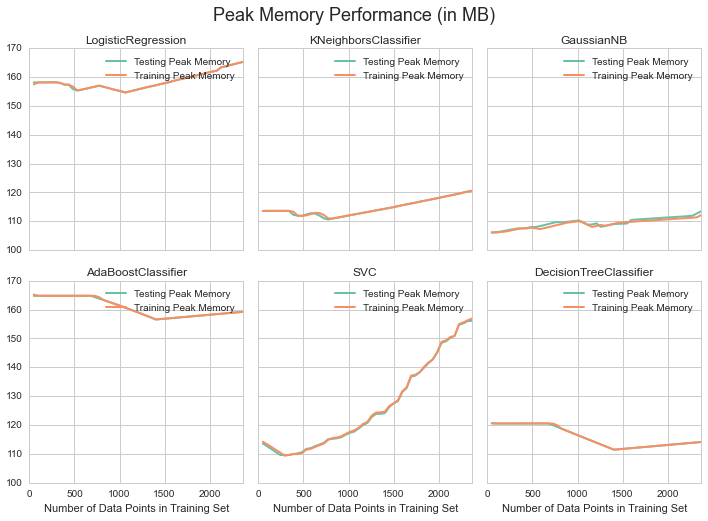

In [19]:
# Train and predict using different training set sizes
#plot the Memory peak curves for all classifiers tested
import matplotlib.pylab as pl
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = pl.subplots(2, 3, sharex='all',
                                                    sharey='all',figsize=(10,7))
l_clf = d_rtn.keys()
i = 0
for s_key, ax in zip(l_clf,[ax1, ax2, ax3, ax4, ax5, ax6]):
    i += 1
    d_aux = d_rtn[s_key]
    ax.plot(d_aux['sizes'], d_aux['arr_memtest'], lw = 2, label = 'Testing Peak Memory')
    ax.plot(d_aux['sizes'], d_aux['arr_memtrain'], lw = 2, label = 'Training Peak Memory')
    ax.legend()
    ax.set_title(d_aux['name'])
    if i>3:
        ax.set_xlabel('Number of Data Points in Training Set')
    ax.set_xlim([0, len(X_trainFake)])

# Visual aesthetics
f.tight_layout()
f.suptitle("Peak Memory Performance (in MB)", fontsize=18, y=1.03)
f.tight_layout()

Below, I have measured the time that each algorithm took to fit the model and to perform the predictions. As expected, $K−NN$ took longer in the testing phase than in the training phase. As instead of  fit a model to the data, it holds the examples to find the closest neighbors, this behaviour was expected. The $SVM$ presented a curious behaviour. The time increased sharply and dropped suddenly. As pointed out in the scikit [documentation](http://scikit-learn.org/stable/modules/svm.html#complexity), the fit time complexity of the SVM is more than quadratic. The time complexity of the $AdaBoost$ Classifier depends on the [number of base learners](http://stackoverflow.com/questions/22397485/what-is-the-o-runtime-complexity-of-adaboost) used ($Decision Tree$ and the maximum 50, respectively). The time to fit the model has increased with more data, although the time to predict was kept at an acceptable level.

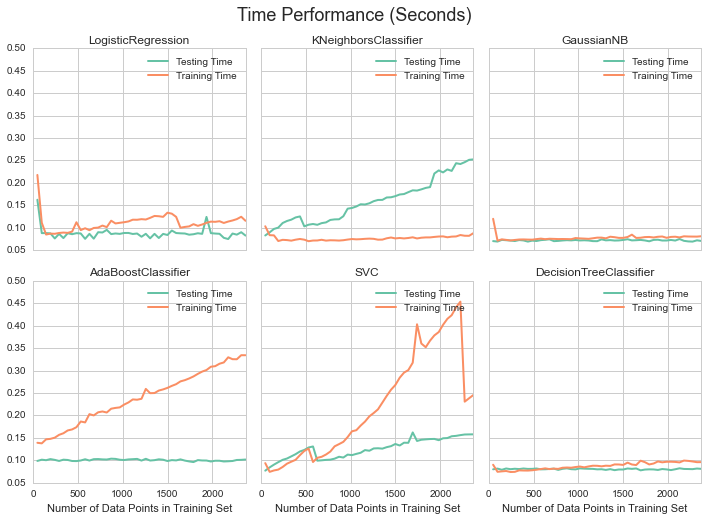

In [20]:
# Train and predict using different training set sizes
#plot the Memory peak curves for all classifiers tested
import matplotlib.pylab as pl
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = pl.subplots(2, 3, sharex='all',
                                                    sharey='all',figsize=(10,7))
l_clf = d_rtn.keys()
i = 0
for s_key, ax in zip(l_clf,[ax1, ax2, ax3, ax4, ax5, ax6]):
    i += 1
    d_aux = d_rtn[s_key]
    ax.plot(d_aux['sizes'], d_aux['arr_timetest'], lw = 2, label = 'Testing Time')
    ax.plot(d_aux['sizes'], d_aux['arr_timetrain'], lw = 2, label = 'Training Time')
    ax.legend()
    ax.set_title(d_aux['name'])
    if i>3:
        ax.set_xlabel('Number of Data Points in Training Set')
    ax.set_xlim([0, len(X_trainFake)])

# Visual aesthetics
f.tight_layout()
f.suptitle("Time Performance (Seconds)", fontsize=18, y=1.03)
f.tight_layout()

Considering the resources constraints, I will keep testing just the models that presented a relatively stable time both to test and to predict. In the next section, I will analyse the $F_1$ score of the $Gaussian Naive Bayes$, $Decision Tree$ and $Logistic Regression$.

### 4.2. Performance Test

In this subsection, I will analyse each model chosen in the last section, presenting a brief explanation about each one and examining its learning curves.

In [20]:
import matplotlib.pylab as pl

def learningCurve(s_algo):
    '''
    Plot the Learnings Curves of a specific algorithm
    :param s_algo: string. Name of the algo to be plotted
    '''
    f, ax = pl.subplots(1, 1)
    d_aux = d_rtn[s_algo]
    ax.plot(d_aux['sizes'], d_aux['arr_F1test'], lw = 2, label = 'Testing Score')
    ax.plot(d_aux['sizes'], d_aux['arr_F1train'], lw = 2, label = 'Training Score')
    ax.legend()
    ax.set_title("{} F1 Score\n".format(d_aux['name']), fontsize=18)
    ax.set_xlabel('Number of Data Points in Training Set')
    ax.set_ylabel("Score")
    ax.set_xlim([0, len(X_train)])
    ax.set_ylim([0., 1.03])

    # Visual aesthetics
    f.tight_layout()
    f.tight_layout()

In [21]:
def makeTable(d_rtn, s_key):
    '''
    Return a dataframe with the F1 score and time to training
    and test set
    :param d_rtn: dictionary. All tests made to the required algos
    :param s_key: string. The name in the dict of the algo desired
    '''
    d_table = {}
    d_table["F1 score on test set"] = d_rtn[s_key]["arr_F1test"]
    d_table["F1 score on training set"] = d_rtn[s_key]["arr_F1train"]
    d_table["training time (secs)"] = d_rtn[s_key]["arr_timetrain"]
    d_table["prediction time (secs)"] = d_rtn[s_key]["arr_timetest"]

    df = pd.DataFrame(d_table, index=d_rtn[s_key]["sizes"])
    df = df.loc[[103, 200, 296]]
    df.index = [["Training set size"]*3, [103, 200, 296]]
    df = df.T
    df = df.loc[[u'prediction time (secs)', u'training time (secs)',
                 u'F1 score on test set', u'F1 score on training set']]
    df = df.applymap(lambda x: "{0:.4f}".format(x))    
    return df

In [24]:
#create a list pf classifiers to be tested
l_clf = [GaussianNB(), DecisionTreeClassifier(random_state=0), AdaBoostClassifier(random_state=0),
         LogisticRegression(random_state=0)]

# TODO: Train and predict using two other models

d_rtn = {}
# Fit model to training data
for clf in l_clf:
    s_key = clf.__class__.__name__
    d_rtn[s_key] = makeArrToMakeCurves(clf, X_train, y_train, X_test, y_test)
    time.sleep(10)
print "Done!"

Done!


#### 4.2.1. Naive Bayes

According to \cite{Mitchell}, one highly pratical Bayesian learning method is the naive Bayes learner. Its performance has been shown to be comparable to neural network and decision tree learning in some domains. The model assumes that each feature is conditionally independent given a target value:

$$\upsilon_{NB} = \arg\max_{v_j \in V}P(\upsilon_j) \prod_i P(a_i | \upsilon_j) $$

Where $\upsilon_{NB}$ is the label (passed or not passed, in this case) that maximize this calculation. The model classifies any data point by multiplying the probability of a particular class and the likelihood of observing each feature given that class.

\cite{Hastie_2009} says that, while the model assumption is generally not true, it does simplify the estimation drastically. it also indicates that the probability of a given event probability might be wrong, but the conclusion will be right.

In the Figure below, it is possible to see that the $F_1$ score stabilize already around 100 datapoints used to fit the model, but its maximum score it achieved when more data is added (using 296 data points). The trining and test time are pretty close, as shown in the Figure~\ref{fig:timetest}.

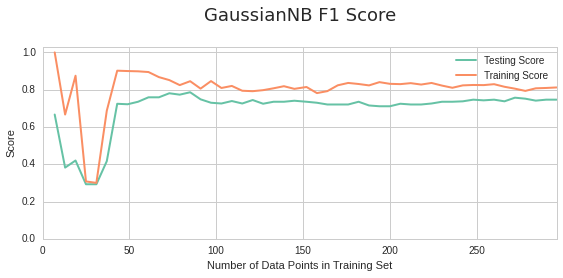

In [21]:
learningCurve("GaussianNB")

In [52]:
makeTable(d_rtn, "GaussianNB")

Training set size                
                                       103     200     296
prediction time (secs)              0.0889  0.0801  0.0890
training time (secs)                0.0708  0.0862  0.0803
F1 score on test set                0.7259  0.7111  0.7465
F1 score on training set            0.8092  0.8315  0.8120

The [sklearn documentation](http://scikit-learn.org/stable/modules/naive_bayes.html) states that  one of the common use of the algorithm is in classification and spam filtering. The model requires a small amount of training data to estimate the necessary parameters.

Some of the pros of this model are: inference is cheap; the model has few parameters; empirically succesful. A negative side is that the assumption that the attributes be conditional independent of each other is too strong. For example, it can't [learn](http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/) interactions between labels.

Given the resource consumption of the Naive Bayes to train and predict and the $F_1$ Score achieved, this model seems a strong candidate for the final model.

#### 4.2.2. Decision Tree

\cite(Mitchell) explained that Decision tree is a method for approximating discrete-valued functions that are robust to noisy data and capable of learning disjunctive expressions. The model classifies instances by sorting them down the tree from the root to some leaf node (which is the label of the data).  It has been applied to a broad range of tasks from learning to diagnose medical cases to learning to assess credit risk of loan applicants.

The Scikit-learn uses an optimised version of the CART (Classification and regression trees) algorithm, that [basically](http://scikit-learn.org/stable/modules/tree.html#tree) constructs binary trees using the feature and threshold that yield the largest information gain at each node. So, as shown by \cite{Hastie_2009}, given that there are 2 classes in the dataset (or regions $R_1$ and $R_2$):

$$f(x) = \sum_{m=1}^2 c_m I(x \in R_m)$$

Where:
- $\hat{c}_m = ave(y_i|x_i \in R_m)$
- $R_1 (j,s) = \{ X | X_{j}<s\}$ and $R_2 (j,s) = \{ X | X_{j}>s\}$

$I()$ is an [indicator function](https://en.wikipedia.org/wiki/Indicator_function) and $\hat c$ is what should be minimized by tweaking the combination of the splitting feature and the split point $(j,s)$. The procedure to minimize $\hat c$ can be found in scikit-learn [documentation](http://scikit-learn.org/stable/modules/tree.html#tree).

The figure below shows clearly that the model overfits the Training Data set, although it seems that didn't affect the $F_1$ score in the test set. Instead, it continues to grow significantly when more data is added. The time to train and test is similar to the $GaussianNB$ results.

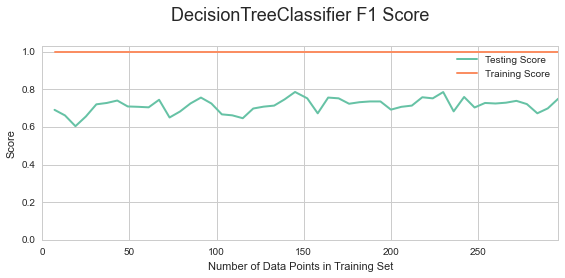

In [53]:
learningCurve("DecisionTreeClassifier")

In [54]:
makeTable(d_rtn, "DecisionTreeClassifier")

Training set size                
                                       103     200     296
prediction time (secs)              0.0888  0.0788  0.0924
training time (secs)                0.0767  0.0818  0.0842
F1 score on test set                0.6667  0.6917  0.7500
F1 score on training set            1.0000  1.0000  1.0000

Still according to the documentation, some advantages of decision trees are: Decision Trees are simple to understand and to interpret, as they can be visualised; Requires little data preparation (like normalization); Performs well even if its assumptions are somewhat violated by the true model; The cost of using the tree is logarithmic in the number of data points used in the training phase.

The disadvantages include: it can create over-complex trees that do not generalise the data well; and if some classes dominate,the tree can be biased. Many disadivantages of this algorithm is mitigated by using decision trees within an ensemble, like $AdaBoost$.


An advantage of the $Decision Tree$ algorithm over the $GuassianNB$ is that it could be visualized, what would make it easier to explain to someone without knowledge about Machine Learning. However, It took more data to fit a similar model regarding $F_1$ score when compared to the last method. Also, this particular dataset is imbalanced (there are 60% of passed and 30% of not passed), and it can be an issue. Using the model within an ensemble method, as suggest in the last paragraph, is not feasible given the time to train the model, as shown in the Figure about time consumed.

#### 4.2.3. Logistic Regression

Contrary to its name, logistic regression is a classification method that performs a regression in a logistic (or [sigmoid](https://en.wikipedia.org/wiki/Generalised_logistic_function)) function (\cite{richert2013building}). In \cite{Hastie_2009} book is said that this model is widely used in biostatistical applications where binary responses occur quite frequently. For instance, patients survive or die, have heart disease or not and so on. This model is usually fit by maximum likelihood, using the conditional probability of $G$ given $X$. The general log-likelihood that should be maximized to $\theta$(that will result in the $\beta$ parameters of the function) is:

$$l(\theta) = \sum_{i=1}^{N} \log{p_{g_{i}}(x_i; \theta)}$$

Where $p_{k}(x_i ; \theta) = Pr(G=k | X = x_i ; \theta)$ and the probabilities sum up to 1. The default implementation of _Scikit-Learn_ solves the maximization problem using the C++ library "liblinear" and a penalization function called L2. More detail can be found in the [documentation](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).

Looking at the Figure below, the $F_1$ score stabilize just after 200 data point in the training set, increasing a little bit when the data available grows to 296 points. The time both to training and to predict is less stable than the last models, but it still holds in a acceptable level.

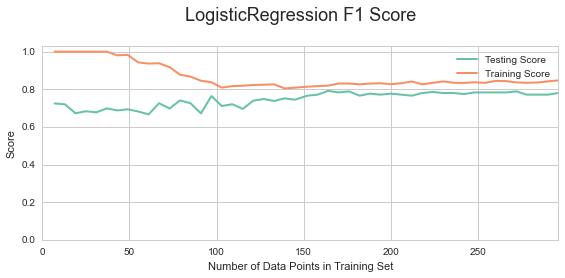

In [57]:
learningCurve("LogisticRegression")

In [58]:
makeTable(d_rtn, "LogisticRegression")

Training set size                
                                       103     200     296
prediction time (secs)              0.0868  0.0922  0.0662
training time (secs)                0.0820  0.0889  0.0839
F1 score on test set                0.7111  0.7770  0.7801
F1 score on training set            0.8088  0.8269  0.8474

Some [advantages](https://www.quora.com/What-are-the-advantages-of-logistic-regression-over-decision-trees) of Logistic Regression are that the model is fast, is less sophisticated and easy to inspect. Some of the [downsides](http://d-scholarship.pitt.edu/7034/1/realfinalplus_ETD2006.pdf) are are that, as any linear model, it is not robust to outliers, and can't handle imbalance data efficiently.

## 5. Choosing the Best Model

```
Udacity:
- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F1 score?
```
In this section, I will choose the model that best filled the requirements of limited resources and performance based on the experiments I have performed earlier. Thus, I will describe the algorithm in Layman's terms and, finally, tune it using Grid Search.

### 5.1. Choosing the Optimal Model

The $Logistic Regression$ model is the simplest of all algorithms tested and presented a remarkable performance, especially considering the imbalanced dataset used to train the model. Even if this model had presented a performance similar to the other algorithms, it should be considered as the best one due to the Occam's Razor: "Among competing hypotheses, the one with the fewest assumptions should be selected".

Considering the time performance, the results of the $Logistic Regression$ was less stable than the other algorithms, when we look at the tables. For instance, the records show that it took $0.0992$ seconds to predict with 200 data points in the training set, against $0.0788$ of the $Decision Tree$ and $0.0801$ of the $GaussianNB$. However, the prediction time of the $Logistic Regression$ was the best one when used 296 data points. It dropped to $0.0662$ seconds to predict, against $0.0924$ from the $Decision Tree$ and $0.0890$ from the Naive Bayes. Overall, the time performance of the algorithm remained at an acceptable level, as can see in the Figure~\ref{fig:timetest}.

Comparing $Logistic Regression$ to $Decision Tree$, it has already achieved a $F_1$ score greater than $0.70$ using just 100 data point to fit the model, while the $Decision Tree$ took around 200 data point to achieve that. Comparing to $GuassianNB$, using 200 data points the Naive Bayes presented a $F_1$ score of $0.7111$. The $Logistic regression$, $0.7770$. Also, it seems that this amount of data is enough for the model, given that adding more 96 data points just increased the $F_1$ score just $0.003$ units. 

### 5.2. Describing the Model in Layman’s Terms

As explained before, logistic regression is a classification method that performs a regression in a logistic function. It fits a model by calculating the maximum likelihood, using the conditional probability of G given X. 

In layman terms, it means that the model estimates its [predictions](https://www.quora.com/What-is-logistic-regression) using probability. The function [approaches](https://www.quora.com/What-is-logistic-regression/answer/Alaka-Halder) $0$ and $1$, getting closer and closer to those values as the feature value grows, but never reaching them. So, the answer to the model always stays within the [$0$, $1$] range. 

To illustrate the way the model works, in the Figure~\ref{fig:logitreg} below,  at the right, I plotted an artificial feature value on the X axis with the corresponding class range, either $0$ or $1$, on the Y axis. What logistic regression does is measure the probability that a given value of a feature to belong to the class $1$. Once the model is fitted to the data,  I could predict class $1$ if $P(feature) > 0.5$, or class $0$ otherwise. It is illustrated in the chart at the left.

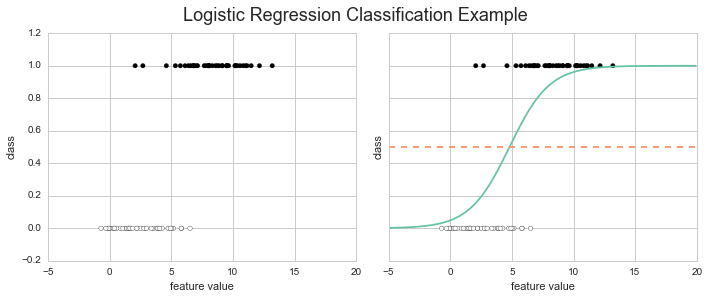

In [30]:
# code based on:
# https://github.com/luispedro/BuildingMachineLearningSystemsWithPython/blob/first_edition/ch05/log_reg_example.py

# import libraries needed
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
    
# create a random sample nomrally distributed
num_per_class = 40
X = np.hstack((norm.rvs(2, size=num_per_class, scale=2),
              norm.rvs(8, size=num_per_class, scale=3)))
y = np.hstack((np.zeros(num_per_class),
               np.ones(num_per_class)))

# define the function to trabsform the logistic regression output into probability
def lr_model(clf, X):
    '''
    Transform the logistic regression model to be between 0 and 1
    '''
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

# fit the model
logclf = LogisticRegression()
logclf.fit(X.reshape(num_per_class * 2, 1), y)

# create a ordered sample to plot the logistic model line
X_test = np.arange(-5, 20, 0.1)

# plot the chart 1
f, ((ax1), (ax2)) = pl.subplots(1, 2, sharex='all', sharey='all',figsize=(10,4))
ax1.set_xlim((-5, 20))
ax1.scatter(X, y, c=y)
ax1.set_xlabel("feature value")
ax1.set_ylabel("class")

# plot the chart 2
ax2.set_xlim((-5, 20))
ax2.scatter(X, y, c=y)
ax2.plot(X_test, lr_model(logclf, X_test).ravel())
ax2.plot(X_test, np.ones(X_test.shape[0]) * 0.5, "--")
ax2.set_xlabel("feature value")
ax2.set_ylabel("class")

# Visual aesthetics
f.tight_layout()
f.suptitle("Logistic Regression Classification Example", fontsize=18, y=1.03)
f.tight_layout()

So, for example, using the model above, a feature value of $-1$ would be assigned a probability of 4% of the observation is part of class 1. As it is below the 0.5 line (the dotted line), the model would assign class 0 to this instance. If the feature value were 7, the probability would be 89%, and the model would say that the observation is part of class 1.

In [22]:
print("P(x=-1)=%.2f\tP(x=7)=%.2f" %
      (lr_model(logclf, -1), lr_model(logclf, 7)))

P(x=-1)=0.04	P(x=7)=0.89


In the context of this project, 0 means that the model is entirely sure that the student will fail to pass, and 1 means that it is absolutely certain that student will pass. Any value above 0.5 means that the model is pretty sure that the students will succeed, so it classifies as "passed."

### 5.3. Model Tuning

In this section, I will perform a Grid Search through a parameter space looking for the set of parameters that yields the best result. This parameter space is all possible combinations of the following $Logistic Regression$ parameters:

- 'C': [$0.01, 0.1, 0.5, 1., 2., 10., 100.$],
- 'solver': ['newton-cg', 'lbfgs', 'liblinear'] 

Where _C_ is the Inverse of regularization strength and _solver_ is the algorithm used in the optimization problem. To determine the "best result," Grid Search use a 3-fold Cross-validation procedure. Basically, it separates a sample into three subsets and uses one partition to train the model and another to verify its performance. Then, the procedure is run multiple times using different subsets to train and validate the model. The results are averaged over the rounds.

In [ ]:
# TODO: Fine-tune your model and report the best F1 score

In [25]:
# import libraries needed
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

def performance_metric(y_true, y_predict):
    """
    Calculates and returns the F1 score between true and predicted values
    :param y_true: numpy array. The output desired of each instance
    :param y_predict: numpy array. The output calculated of each instance
    """
    error = f1_score(y_true, y_predict, pos_label='yes')
    return error


def fit_model(X, y):
    """ 
    Tunes a Logistic Regression classifier model using GridSearchCV on the
    input data X and target labels y and returns this optimal model.
    :param X: numpy array. The features used to train the model
    :param y: numpy array. The output desired of each instance
    """

    # Create the classifier object
    classifier = LogisticRegression()

    # Set up the parameters we wish to tune
    parameters = { # Inverse of regularization strength
                  'C': [0.01, 0.1, 0.5, 1., 2., 10., 100.],
                   # Algorithm to use in the optimization problem}
                  'solver': ['newton-cg', 'lbfgs', 'liblinear'] 
                  }

    # Make an appropriate scoring function
    scoring_function = make_scorer(performance_metric,
                                   greater_is_better=True)

    # Make the GridSearchCV object
    clf = GridSearchCV(classifier,
                       param_grid=parameters,
                       scoring=scoring_function)

    # Fit the learner to the data to obtain the optimal model with tuned parameters
    clf.fit(X, y)

    # Return the optimal model
    return clf


# Test fit_model
try:
    clf = fit_model(X_train, y_train)
    print "Successfully fit a model!"
except:
    print "Something went wrong with fitting a model."

Successfully fit a model!


The best parameters found were:

In [26]:
print clf.best_params_

{'C': 0.01, 'solver': 'liblinear'}


To make sure that they are the best one trully, I am going to run the same test multiple times to see what were the parameters found at each iterations

In [27]:
# Run multiples iterations to find the best parameter for the model.
l_Optimal_paramns = []
d_rtn = {}
for i_try in xrange(1, 10):
    clf = fit_model(X_train, y_train)
    l_Optimal_paramns.append(clf.best_params_)
    if clf.best_params_ not in d_rtn.keys():
        d_rtn[str(clf.best_params_)] = clf
l_Optimal_paramns

[{'C': 0.01, 'solver': 'liblinear'},
 {'C': 0.01, 'solver': 'liblinear'},
 {'C': 0.01, 'solver': 'liblinear'},
 {'C': 0.01, 'solver': 'liblinear'},
 {'C': 0.01, 'solver': 'liblinear'},
 {'C': 0.01, 'solver': 'liblinear'},
 {'C': 0.01, 'solver': 'liblinear'},
 {'C': 0.01, 'solver': 'liblinear'},
 {'C': 0.01, 'solver': 'liblinear'}]

Finally, calculating the $F_1$ score using the classifier tuned I got:

In [29]:
s_rtn = ""
X_train ,y_train, X_test, y_test = shuffle_split_data(X_all1, y_all)
f_f1Train, f_timeTrain2, f_memTrain2 = predict_labels(clf, X_train, y_train, shouldPrint=False)
s_rtn += "F1 score for training set: {:0.3f}".format(f_f1Train)
f_f1Test, f_timeTest, f_memTest = predict_labels(clf, X_test, y_test, shouldPrint=True)
s_rtn += "\nF1 score for test set: {:0.3f}".format(f_f1Test)
print s_rtn

Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.079
Peak memory: 184.21 MiB
F1 score for training set: 0.826
F1 score for test set: 0.787


As was expected, after tuning the model, it performed just slightly better than the default parameters, achieving a $F_1$ score in the test set of $0.787$ against $0.7801$ obtained before. The prediction time got a little worse than before ($0.0662$).

## Reflection

Although I have found an appropriate model to the task at hand, I believe that I should have done some feature engineering or dimensionality reduction. I believe that the most of the models tested would benefit from a dataset with less dimensions. It would require the implementation of some new steps, including repeat what was done so far some more times. It may seem odd perform the whole process again and again, but in the data science workflow, it is expected. After all, as I have been learning at Udacity courses, Machine Learning can be very iterative.

_Style notebook and change matplotlib defaults_

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML( open('ipython_style.css').read())

In [7]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))